In [133]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

from main_funcs import get_and_update_data

In [134]:
# configs
country=None
joft = "BTCUSDT"
interval = "1h"

# remove small candle 
zero_remover_pct = 0.00

# add history of open_close_pct 
open_close_pct_history_count = 60

# add history of max_low_high_pct 
max_low_high_pct_history_count = -1

# calculate rsi with different lengths 
rsi_ranges = range(14, 14)

# add history of rsi
rsi_history_count = 0

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [135]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [136]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [137]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

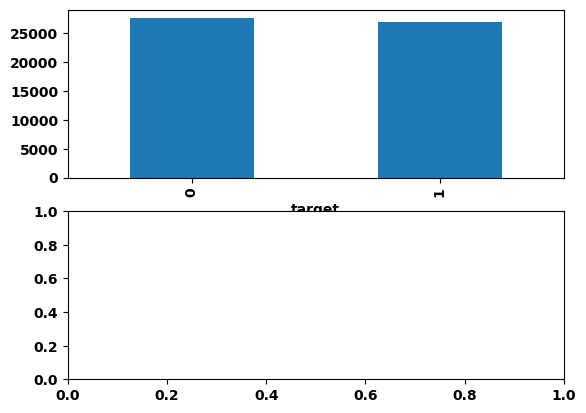

In [138]:
# create calculate target
df_target = df_cal.copy()

# calculate target
df_target["target"] = np.where(
    df_target['max_low_high_pct'] > zero_remover_pct,
    1,
    np.where(
        df_target['max_low_high_pct'] < -zero_remover_pct,
        -1, 0
    )
)

# convert -1 and 1 and 0 to True False for better result
df_target["target"] = np.where(df_target['target'] ==1, 1,0)
# df_target["target"] = np.where(df_target['target'] ==1, 1,-1)

# show chart
fig, axs = plt.subplots(2, 1)
df_target["target"].value_counts().plot(kind='bar', ax=axs[0])
# (np.sign(df_target["open_close"]) == np.sign(df_target["target"])).value_counts().plot(kind='bar',ax=axs[1])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [139]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)
df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,open_close_pct__52,open_close_pct__53,open_close_pct__54,open_close_pct__55,open_close_pct__56,open_close_pct__57,open_close_pct__58,open_close_pct__59,open_close_pct__60,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 19:30:00,-0.008966,-0.015989,-0.005802,-0.013470,0.037991,-0.014542,-0.013177,0.017304,-0.008546,0.016213,...,-0.005649,-0.007332,0.004256,0.019266,0.006316,0.007731,-0.001372,0.001506,0.011111,1.0
2017-08-19 20:30:00,0.010632,-0.008966,-0.015989,-0.005802,-0.013470,0.037991,-0.014542,-0.013177,0.017304,-0.008546,...,0.010882,-0.005649,-0.007332,0.004256,0.019266,0.006316,0.007731,-0.001372,0.001506,1.0
2017-08-19 21:30:00,0.018088,0.010632,-0.008966,-0.015989,-0.005802,-0.013470,0.037991,-0.014542,-0.013177,0.017304,...,0.002651,0.010882,-0.005649,-0.007332,0.004256,0.019266,0.006316,0.007731,-0.001372,1.0
2017-08-19 22:30:00,0.000651,0.018088,0.010632,-0.008966,-0.015989,-0.005802,-0.013470,0.037991,-0.014542,-0.013177,...,-0.026501,0.002651,0.010882,-0.005649,-0.007332,0.004256,0.019266,0.006316,0.007731,0.0
2017-08-19 23:30:00,-0.003113,0.000651,0.018088,0.010632,-0.008966,-0.015989,-0.005802,-0.013470,0.037991,-0.014542,...,0.000425,-0.026501,0.002651,0.010882,-0.005649,-0.007332,0.004256,0.019266,0.006316,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13 15:30:00,0.003248,-0.004465,-0.000335,-0.000968,0.001706,-0.000072,0.001247,-0.000285,0.000364,-0.006142,...,-0.001060,-0.002100,0.000260,0.000438,0.000497,-0.001787,0.001431,-0.006528,-0.000131,0.0
2023-11-13 16:30:00,-0.002771,0.003248,-0.004465,-0.000335,-0.000968,0.001706,-0.000072,0.001247,-0.000285,0.000364,...,0.001758,-0.001060,-0.002100,0.000260,0.000438,0.000497,-0.001787,0.001431,-0.006528,0.0
2023-11-13 17:30:00,-0.001087,-0.002771,0.003248,-0.004465,-0.000335,-0.000968,0.001706,-0.000072,0.001247,-0.000285,...,-0.000626,0.001758,-0.001060,-0.002100,0.000260,0.000438,0.000497,-0.001787,0.001431,0.0


In [140]:
# analyse df
print("shape df: ", df.shape)
print(df.corr()['target'].sort_values(ascending=False))

shape df:  (54521, 62)
target                1.000000
open_close_pct__43    0.012101
open_close_pct__57    0.008185
open_close_pct__3     0.008022
open_close_pct__13    0.007474
                        ...   
open_close_pct__24   -0.008819
open_close_pct__48   -0.010394
open_close_pct__0    -0.024610
open_close_pct__1    -0.024706
open_close_pct__23   -0.032012
Name: target, Length: 62, dtype: float64


In [141]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [142]:
# random x and y train and test
# x_train, x_test, y_train, y_test= train_test_split(
#     X, Y, test_size=.15, random_state=123
# )
# test faghat akharin vaziyat va na besorat random
test_point = int(len(X)*0.85)
x_train, x_test, y_train, y_test = X.iloc[:test_point,:],X.iloc[test_point:,:],Y.iloc[:test_point],Y.iloc[test_point:]
 
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_clf.get_params()
xgb_clf.set_params(n_estimators=500)
xgb_clf.fit(x_train, y_train)
y_preds = xgb_clf.predict(x_test)
accuracy = float(np.sum(y_preds==y_test))/y_test.shape[0]
print("Baseline accuracy:", accuracy)
print(metrics.classification_report(y_test,y_preds))

Baseline accuracy: 0.4974935811223866
              precision    recall  f1-score   support

         0.0       0.50      0.53      0.51      4094
         1.0       0.50      0.46      0.48      4085

    accuracy                           0.50      8179
   macro avg       0.50      0.50      0.50      8179
weighted avg       0.50      0.50      0.50      8179


In [143]:
################################################
# yek noe digar baraye mohasebe
# cross validator
################################################

In [144]:
# model with cross validation
d_matrix = xgb.DMatrix(data=X, label=Y)
params = {
    'max_depth': 50 # count of tree in jungle
}
xgb_cv = xgb.cv(
    dtrain=d_matrix, 
    params=params, 
    nfold=5, # tedad ghesmatha baraye cross validation
    num_boost_round=10, # tedad max_depth agar model behtar nashod
    seed=123, # seed random baraye random haye moshabeh 
    metrics=['error'] # noe mohasebe baraye cross validation
)
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.000142,0.000240,0.499661,0.002329
1,0.000037,0.000037,0.498670,0.002439
2,0.000000,0.000000,0.499367,0.003256
3,0.000000,0.000000,0.499110,0.001922
4,0.000000,0.000000,0.498689,0.002620
5,0.000000,0.000000,0.498358,0.002476
6,0.000000,0.000000,0.498579,0.003013
7,0.000000,0.000000,0.498835,0.002730
8,0.000000,0.000000,0.498487,0.002826
9,0.000000,0.000000,0.498909,0.001729
